In [1]:
!unzip /content/Brain_tumor_dataset.zip -d /content/Brain_tumor_dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/Brain_tumor_dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/Brain_tumor_dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/Brain_tumor_dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/Brain_tumor_dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/Brain_tumor_dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/Brain_tumor_dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/Brain_tumor_dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/Brain_tumor_dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/Brain_tumor_dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/Brain_tumor_dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/Brain_tumor_dataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/Brain_tumor_dataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/Brain_tumor_dataset/Trainin

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os


In [3]:
data_dir = "/content/Brain_tumor_dataset"

train_dir = os.path.join(data_dir, "Training")
test_dir  = os.path.join(data_dir, "Testing")

IMG_SIZE   = 224
BATCH_SIZE = 32

In [4]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


num_classes = train_generator.num_classes
print("Classes:", train_generator.class_indices)
print("num_classes =", num_classes)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
num_classes = 4


In [5]:
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = inputs



x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)


outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy','precision','recall']
)


In [7]:
checkpoint_path = "efficientnetb0_brain_tumor_multiclass.best.keras"

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-7
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False
    )
]


In [8]:
EPOCHS = 10

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 134s 738ms/step - accuracy: 0.2516 - loss: 1.4078 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2796 - val_loss: 1.3839 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 481ms/step - accuracy: 0.2561 - loss: 1.3961 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2796 - val_loss: 1.3840 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 487ms/step - accuracy: 0.2484 - loss: 1.3973 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2796 - val_loss: 1.3831 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 488ms/step - accuracy: 0.2791 - loss: 1.3924 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2796 - val_loss: 1.3835 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

In [9]:
results = model.evaluate(test_generator)
test_loss = results[0]
test_acc = results[1]

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 343ms/step - accuracy: 0.1600 - loss: 1.4246 - precision: 0.0000e+00 - recall: 0.0000e+00
Test loss: 1.3781
Test accuracy: 0.3089


In [10]:
from tensorflow.keras.optimizers import Adam


N_FINE_TUNE = 40

base_model.trainable = True


total_layers = len(base_model.layers)
fine_tune_from = total_layers - N_FINE_TUNE

print("Total layers in base_model:", total_layers)
print(f"Fine-tuning from layer {fine_tune_from} to {total_layers-1}")

for i, layer in enumerate(base_model.layers):
    layer.trainable = (i >= fine_tune_from)


for i, layer in enumerate(base_model.layers[-50:]):
    print(i + total_layers - 50, layer.name, "trainable:", layer.trainable)


model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 10

history_fine = model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=val_generator,
    callbacks=callbacks
)

test_loss, test_acc = model.evaluate(test_generator)
print("After fine-tuning:")
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


Total layers in base_model: 238
Fine-tuning from layer 198 to 237
188 block6b_project_conv trainable: False
189 block6b_project_bn trainable: False
190 block6b_drop trainable: False
191 block6b_add trainable: False
192 block6c_expand_conv trainable: False
193 block6c_expand_bn trainable: False
194 block6c_expand_activation trainable: False
195 block6c_dwconv trainable: False
196 block6c_bn trainable: False
197 block6c_activation trainable: False
198 block6c_se_squeeze trainable: True
199 block6c_se_reshape trainable: True
200 block6c_se_reduce trainable: True
201 block6c_se_expand trainable: True
202 block6c_se_excite trainable: True
203 block6c_project_conv trainable: True
204 block6c_project_bn trainable: True
205 block6c_drop trainable: True
206 block6c_add trainable: True
207 block6d_expand_conv trainable: True
208 block6d_expand_bn trainable: True
209 block6d_expand_activation trainable: True
210 block6d_dwconv trainable: True
211 block6d_bn trainable: True
212 block6d_activation 

In [11]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

print("TensorFlow version:", tf.__version__)


data_dir = "/content/Brain_tumor_dataset"

train_dir = os.path.join(data_dir, "Training")
test_dir  = os.path.join(data_dir, "Testing")

IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

print("Train dir:", train_dir)
print("Test dir :", test_dir)


train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
print("Class indices:", class_indices)


labels = train_generator.classes

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)


base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = inputs
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.summary()


checkpoint_path = "best_efficientnet_braintumor.keras"

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


base_epochs = 8

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_stage1 = model.fit(
    train_generator,
    epochs=base_epochs,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

print("Stage 1 done.")


N_FINE_TUNE = 40

base_model.trainable = True

total_layers = len(base_model.layers)
fine_tune_from = max(0, total_layers - N_FINE_TUNE)

print("Total layers in base_model:", total_layers)
print(f"Fine-tuning from layer index {fine_tune_from} to {total_layers - 1}")

for i, layer in enumerate(base_model.layers):
    if i < fine_tune_from:
        layer.trainable = False
    else:
        layer.trainable = True


for i, layer in enumerate(base_model.layers[-10:]):
    print(f"{total_layers - 10 + i}: {layer.name}, trainable={layer.trainable}")


model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 10

history_stage2 = model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

print("Stage 2 (fine-tuning) done.")


print("Evaluating on test set...")
test_loss, test_acc = model.evaluate(test_generator)
print("Final Test loss: {:.4f}".format(test_loss))
print("Final Test accuracy: {:.4f}".format(test_acc))


TensorFlow version: 2.19.0
Train dir: /content/Brain_tumor_dataset/Training
Test dir : /content/Brain_tumor_dataset/Testing
Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Class weights: {0: np.float64(1.0811258278145695), 1: np.float64(1.0659981343283582), 2: np.float64(0.8955721003134797), 3: np.float64(0.9800600343053173)}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.5784 - loss: 0.9679
Epoch 1: val_loss improved from inf to 0.77775, saving model to best_efficientnet_braintumor.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 110s 631ms/step - accuracy: 0.5793 - loss: 0.9664 - val_accuracy: 0.6994 - val_loss: 0.7777 - learning_rate: 0.0010
Epoch 2/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8425 - loss: 0.4844
Epoch 2: val_loss improved from 0.77775 to 0.71280, saving model to best_efficientnet_braintumor.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 479ms/step - accuracy: 0.8425 - loss: 0.4843 - val_accuracy: 0.7353 - val_loss: 0.7128 - learning_rate: 0.0010
Epoch 3/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8600 - loss: 0.4194
Epoch 3: val_loss improved from 0.71280 to 0.65506, saving model to best_efficientnet_braintumor.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 595ms/step - accuracy: 0.8600 - loss: 0.4194 - val_accuracy: 0.7493 - val_loss: 0.6551 - learning_rate: 0.0010
E

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step
[[239  49   0  12]
 [ 22 202  38  44]
 [  5   7 389   4]
 [  2   0   0 298]]
              precision    recall  f1-score   support

      glioma       0.89      0.80      0.84       300
  meningioma       0.78      0.66      0.72       306
     notumor       0.91      0.96      0.94       405
   pituitary       0.83      0.99      0.91       300

    accuracy                           0.86      1311
   macro avg       0.85      0.85      0.85      1311
weighted avg       0.86      0.86      0.86      1311



In [13]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

print("TensorFlow version:", tf.__version__)


data_dir = "/content/Brain_tumor_dataset"

train_dir = os.path.join(data_dir, "Training")
test_dir  = os.path.join(data_dir, "Testing")

IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

print("Train dir:", train_dir)
print("Test dir :", test_dir)


train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.10,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
print("Class indices:", class_indices)


labels = train_generator.classes

base_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(base_class_weights))


if "meningioma" in class_indices:
    meningioma_idx = class_indices["meningioma"]
    class_weights[meningioma_idx] = float(class_weights[meningioma_idx] * 1.5)

print("Base class weights:", dict(enumerate(base_class_weights)))
print("Adjusted class weights (V2):", class_weights)


base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = inputs
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.summary()


checkpoint_path = "best_efficientnet_braintumor_v2.keras"

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)


base_epochs = 8

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=loss_fn,
    metrics=['accuracy']
)

history_stage1 = model.fit(
    train_generator,
    epochs=base_epochs,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

print("Stage 1 (head training) done.")


N_FINE_TUNE = 120

base_model.trainable = True

total_layers = len(base_model.layers)
fine_tune_from = max(0, total_layers - N_FINE_TUNE)

print("Total layers in base_model:", total_layers)
print(f"Fine-tuning from layer index {fine_tune_from} to {total_layers - 1}")

for i, layer in enumerate(base_model.layers):
    layer.trainable = (i >= fine_tune_from)


for i, layer in enumerate(base_model.layers[-10:]):
    print(f"{total_layers - 10 + i}: {layer.name}, trainable={layer.trainable}")


model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=loss_fn,
    metrics=['accuracy']
)

fine_tune_epochs = 30

history_stage2 = model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

print("Stage 2 (fine-tuning) done.")


print("Evaluating on test set...")
test_loss, test_acc = model.evaluate(test_generator)
print("V2 - Final Test loss: {:.4f}".format(test_loss))
print("V2 - Final Test accuracy: {:.4f}".format(test_acc))


from sklearn.metrics import confusion_matrix, classification_report

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (V2):")
print(cm)

target_names = list(test_generator.class_indices.keys())
print("\nClassification Report (V2):")
print(classification_report(y_true, y_pred, target_names=target_names))


TensorFlow version: 2.19.0
Train dir: /content/Brain_tumor_dataset/Training
Test dir : /content/Brain_tumor_dataset/Testing
Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Base class weights: {0: np.float64(1.0811258278145695), 1: np.float64(1.0659981343283582), 2: np.float64(0.8955721003134797), 3: np.float64(0.9800600343053173)}
Adjusted class weights (V2): {0: np.float64(1.0811258278145695), 1: 1.5989972014925373, 2: np.float64(0.8955721003134797), 3: np.float64(0.9800600343053173)}


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.7095 - loss: 1.0409
Epoch 1: val_loss improved from inf to 0.84277, saving model to best_efficientnet_braintumor_v2.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 120s 690ms/step - accuracy: 0.7100 - loss: 1.0400 - val_accuracy: 0.7362 - val_loss: 0.8428 - learning_rate: 0.0010
Epoch 2/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8349 - loss: 0.8036
Epoch 2: val_loss improved from 0.84277 to 0.82696, saving model to best_efficientnet_braintumor_v2.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 544ms/step - accuracy: 0.8350 - loss: 0.8034 - val_accuracy: 0.7353 - val_loss: 0.8270 - learning_rate: 0.0010
Epoch 3/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.8565 - loss: 0.7630
Epoch 3: val_loss improved from 0.82696 to 0.79993, saving model to best_efficientnet_braintumor_v2.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 544ms/step - accuracy: 0.8565 - loss: 0.7629 - val_accuracy: 0.7625 - val_loss: 0.7999 - learning_rate:

In [14]:
model.save("efficientnet_braintumor_v2.keras")



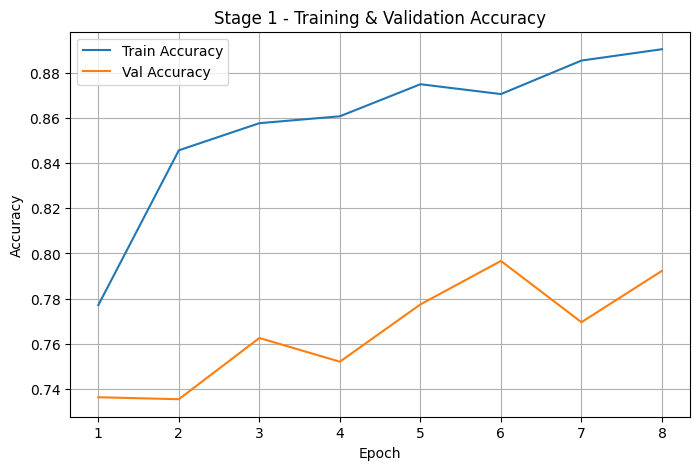

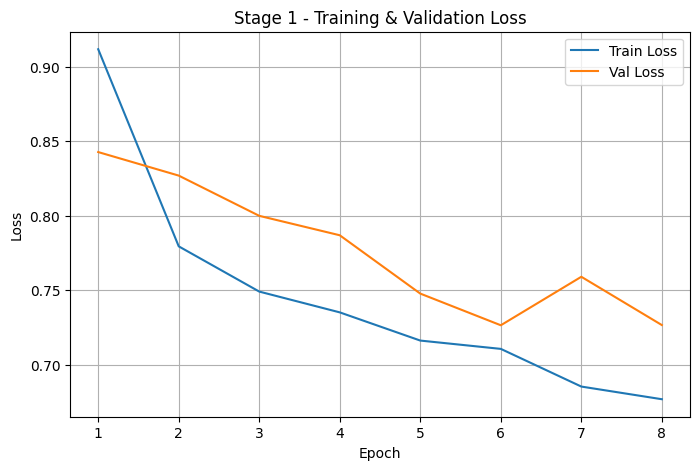

In [15]:
import matplotlib.pyplot as plt

# ----- Stage 1 -----
acc1 = history_stage1.history['accuracy']
val_acc1 = history_stage1.history['val_accuracy']
loss1 = history_stage1.history['loss']
val_loss1 = history_stage1.history['val_loss']

epochs1 = range(1, len(acc1) + 1)

# Accuracy Plot (Stage 1)
plt.figure(figsize=(8,5))
plt.plot(epochs1, acc1, label='Train Accuracy')
plt.plot(epochs1, val_acc1, label='Val Accuracy')
plt.title('Stage 1 - Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot (Stage 1)
plt.figure(figsize=(8,5))
plt.plot(epochs1, loss1, label='Train Loss')
plt.plot(epochs1, val_loss1, label='Val Loss')
plt.title('Stage 1 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


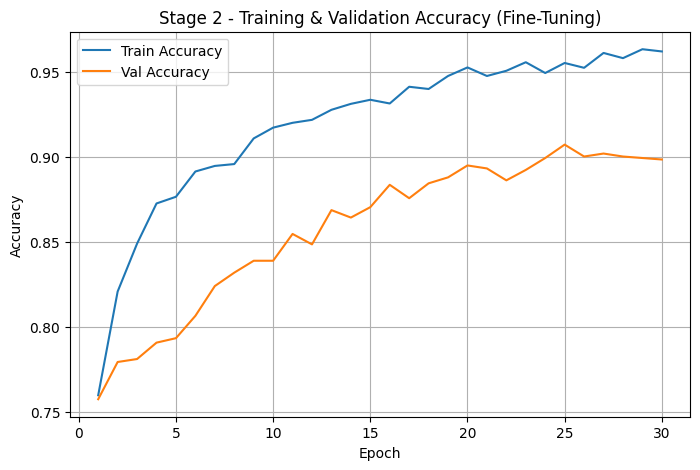

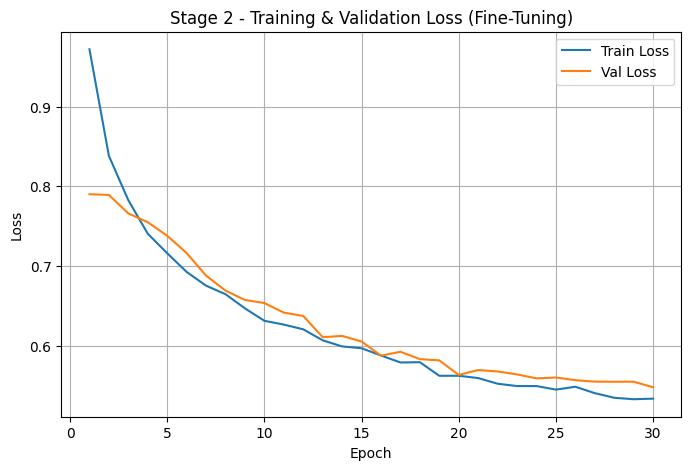

In [16]:
# ----- Stage 2 -----
acc2 = history_stage2.history['accuracy']
val_acc2 = history_stage2.history['val_accuracy']
loss2 = history_stage2.history['loss']
val_loss2 = history_stage2.history['val_loss']

epochs2 = range(1, len(acc2) + 1)

# Accuracy Plot (Stage 2)
plt.figure(figsize=(8,5))
plt.plot(epochs2, acc2, label='Train Accuracy')
plt.plot(epochs2, val_acc2, label='Val Accuracy')
plt.title('Stage 2 - Training & Validation Accuracy (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot (Stage 2)
plt.figure(figsize=(8,5))
plt.plot(epochs2, loss2, label='Train Loss')
plt.plot(epochs2, val_loss2, label='Val Loss')
plt.title('Stage 2 - Training & Validation Loss (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
from google.colab import drive
import shutil
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define source path
source_path = '/content/drive/MyDrive/EfficientnetB0.ipynb'

# 3. Copy if exists
if os.path.exists(source_path):
    shutil.copy(source_path, '/content/')
    print("File copied successfully.")
else:
    print(f"Error: File not found at {source_path}")
    print("Please verify the file name and location in your Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Error: File not found at /content/drive/MyDrive/EfficientnetB0.ipynb
Please verify the file name and location in your Google Drive.


In [18]:
!jupyter nbconvert --to html "EfficientnetB0.ipynb"


[NbConvertApp] WARNING | pattern 'EfficientnetB0.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute


In [19]:
!jupyter nbconvert --to html "EfficientnetB0.ipynb"




[NbConvertApp] WARNING | pattern 'EfficientnetB0.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute


In [20]:
import os
import matplotlib.pyplot as plt

# Create folder for saving plots
save_dir = "efficientnet_plots"
os.makedirs(save_dir, exist_ok=True)

# Example: Save accuracy plot
plt.figure(figsize=(8,6))
plt.plot(history_stage2.history['accuracy'])
plt.plot(history_stage2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.savefig(f"{save_dir}/accuracy.png", dpi=300, bbox_inches='tight')
plt.close()

# Example: Save loss plot
plt.figure(figsize=(8,6))
plt.plot(history_stage2.history['loss'])
plt.plot(history_stage2.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.savefig(f"{save_dir}/loss.png", dpi=300, bbox_inches='tight')
plt.close()

# Repeat for IoU, Dice, Precision, Recall…


In [22]:
import shutil

shutil.make_archive("effecienetnet_plots", 'zip', save_dir)


'/content/effecienetnet_plots.zip'